In [1]:
import emcee
from astropy.cosmology import FlatLambdaCDM
import corner
import scipy.optimize as op
import pandas as pd
import numpy as np
from scipy.optimize import minimize
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from matplotlib import pyplot as plt

In [3]:
tab = pd.read_csv('./lists/salt3_nir_fixed/salt3_nir_fixed.txt', delim_whitespace=True)

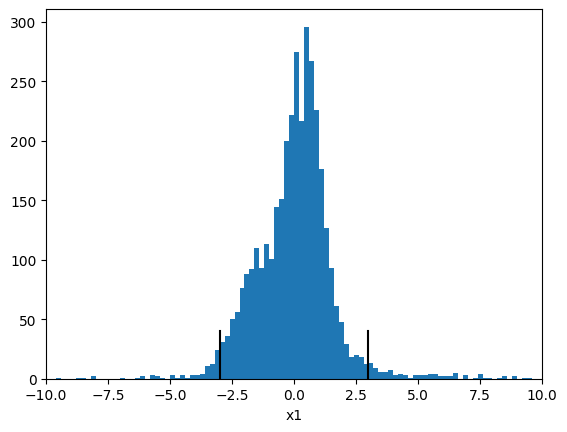

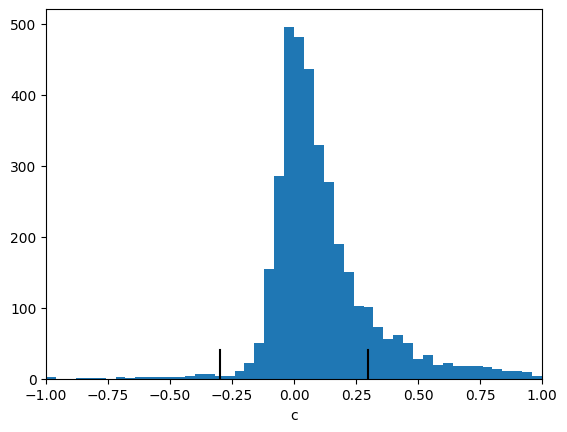

In [4]:
plt.hist(tab.x1,bins=100,range=(-10,10))
plt.xlim(-10,10)
plt.plot([-3,-3],[0,40],c='k')
plt.plot([3,3],[0,40],c='k')
plt.xlabel('x1')
plt.show()

plt.hist(tab.c,bins=500,range=(-10,10))
plt.xlim(-1,1)
plt.plot([-0.3,-0.3],[0,40],c='k')
plt.plot([0.3,0.3],[0,40],c='k')
plt.xlabel('c')
plt.show()

In [5]:
tab=tab[tab.x1 < 3]
tab=tab[tab.x1 > -3]
tab=tab[tab.c > -0.3]
tab=tab[tab.c < 0.3]
tab=tab[tab.x1_err < 1.0]
tab=tab[tab.c_err < 0.3]

tab

,name,z,t0,x0,x1,c,t0_err,x0_err,x1_err,c_err,peakmag_ztfg,peakmag_ztfi,peakmag_ztfr,mag_err
0,ZTF17aadlxmv,0.061960,58878.267347,0.001000,0.416266,0.109712,0.067064,0.000007,0.066245,0.006994,18.038547,18.505413,18.087173,0.008063
2,ZTF18aaajrso,0.074682,58136.760377,0.000571,1.972533,0.142312,2.133772,0.000061,0.826521,0.099207,18.613653,19.054420,18.647620,0.116276
4,ZTF18aaaqexr,0.070227,58893.660178,0.000549,-1.616118,0.108031,0.136159,0.000007,0.172760,0.012557,18.704923,19.137240,18.738574,0.014653
6,ZTF18aabdgik,0.021604,58429.880430,0.007772,-0.766436,0.103534,0.201880,0.000126,0.176727,0.040416,15.824276,16.280041,15.869154,0.017547
8,ZTF18aabssme,0.041680,58185.844897,0.002542,-2.395640,0.036648,0.805985,0.000264,0.618574,0.082535,17.081063,17.622064,17.180848,0.112927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3652,ZTF21aaabviz,0.058197,59220.855251,0.001277,1.051554,-0.024022,0.108834,0.000008,0.076356,0.005822,17.831578,18.541375,18.019193,0.007046
3653,ZTF21aaabvkj,0.080552,59220.239059,0.000557,-1.539638,0.045671,0.175130,0.000006,0.152759,0.011383,18.718866,19.260321,18.815892,0.011768
3654,ZTF21aaabxln,0.076146,59220.311805,0.000917,1.162522,-0.116547,0.216759,0.000008,0.118133,0.007264,18.233203,19.106003,18.514488,0.009990
3657,ZUDS20dlgrv,0.217707,58889.063275,0.000087,-0.518906,0.069026,0.340024,0.000004,0.702747,0.026410,20.719780,21.239675,20.801168,0.045808


In [6]:
def lnlike(p, iz,imb,ist,icol,iemb,iest,iecol):  
    ialpha, ibeta, iMabsB ,isig_sys = p

    model = cosmo.distmod(iz.to_list()).base + iMabsB - ialpha * ist + ibeta * icol
    
    sig_mag=iemb
    sig_st=ialpha*iest
    sig_col=-ibeta*iecol

    sigma_total=(sig_mag)**2+(ialpha*sig_st)**2+(ibeta*sig_col)**2+(isig_sys)**2  
    return -0.5*(np.sum((imb-model)**2/sigma_total+np.log(sigma_total)))

# MARKOV CHAIN MONTE CARLO
def lnprior(p):
    alpha, beta, MabsB ,sig_sys = p
    if (-5.<sig_sys<5.0) and (0.<alpha<1.) and (-2.<beta<6.) and (-21.<MabsB<-15.):
        return 0.0
    return -np.inf

def lnprob(p, z,mb,st,col,emb,est,ecol):
    lp=lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp+lnlike(p, z,mb,st,col,emb,est,ecol)


# tab
z,mb,st,col,emb,est,ecol=tab['z'],tab['peakmag_ztfg'],tab['x1'],tab['c'],tab['mag_err'],tab['x1_err'],tab['c_err']



In [8]:
# Initial values
alpha_i,beta_i,MB_i,sig_sys_i = 0.155,3.17,-19.15,0.15  

# MAXIMUM LIKELIHOOD
nll = lambda *args: -lnlike(*args)
result = minimize(nll, [alpha_i,beta_i,MB_i,sig_sys_i], args=(z,mb,st,col,emb,est,ecol))
print(result["x"])

[  0.10084882   2.69486744 -19.18251996   0.24898074]


In [9]:
# MARKOV CHAIN MONTE CARLO
ndim,nwalkers=4,50
pos=[result["x"]+1.e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler=emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[z,mb,st,col,emb,est,ecol])

# Run MCMC
pos, prob, state  = sampler.run_mcmc(pos, 500)

# Flatten the chain and remove the 150 first steps
nburns=100
samples=sampler.chain[:, nburns:, :].reshape((-1,ndim))

a_mcmc, b_mcmc, m_mcmc , s_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print(a_mcmc, b_mcmc, m_mcmc, s_mcmc)


(0.10059748404347588, 0.004448114570130335, 0.004457214170035445) (2.6953752756634124, 0.035419840880177134, 0.03581911042596131) (-19.18311151474326, 0.00592911654852557, 0.005290419807945312) (0.24910905745969653, 0.004038600544528814, 0.0037698592208741943)


In [10]:
# Calculate the RMS
residuals = mb-m_mcmc[0] + a_mcmc[0] * st - b_mcmc[0] * col-cosmo.distmod(z.to_list()).base
rms = np.sqrt(np.mean(residuals**2))
print('RMS:', rms)

RMS: 0.34832684574000344


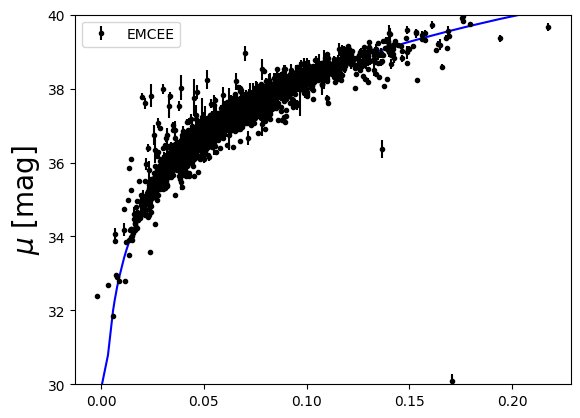

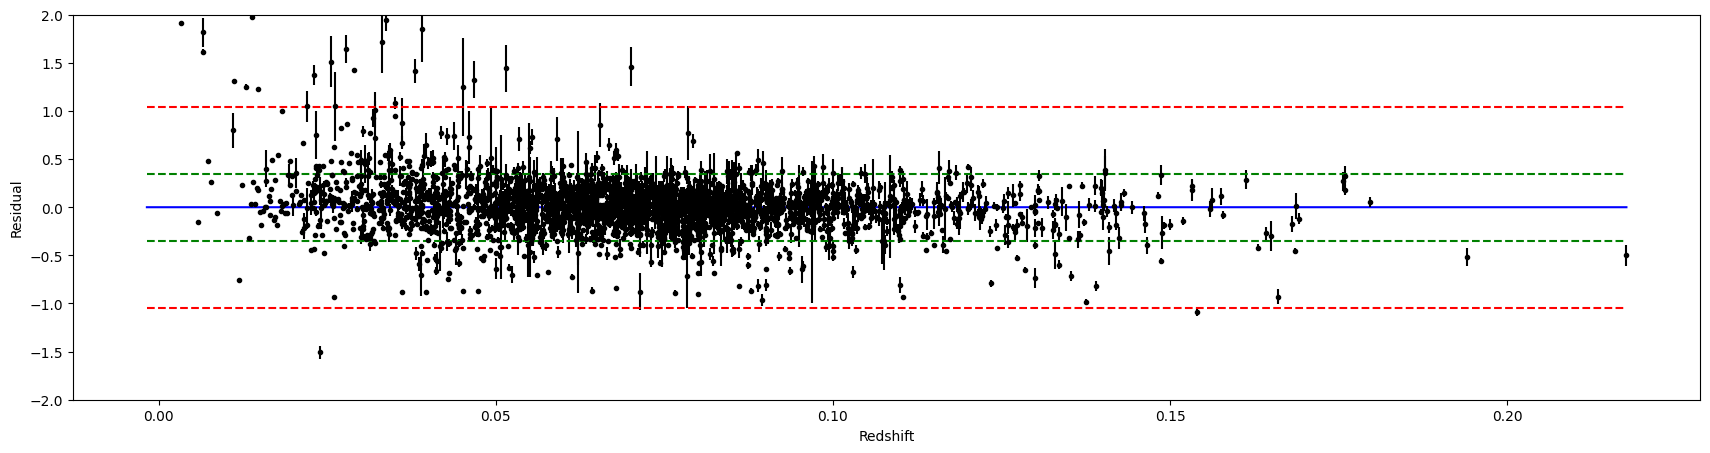

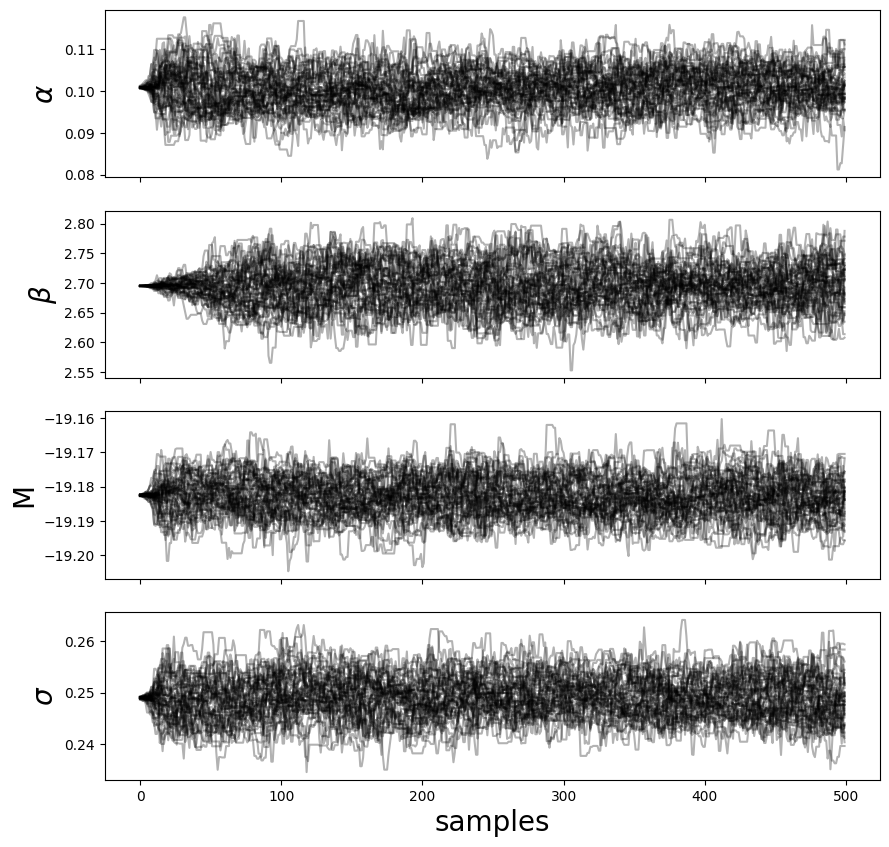

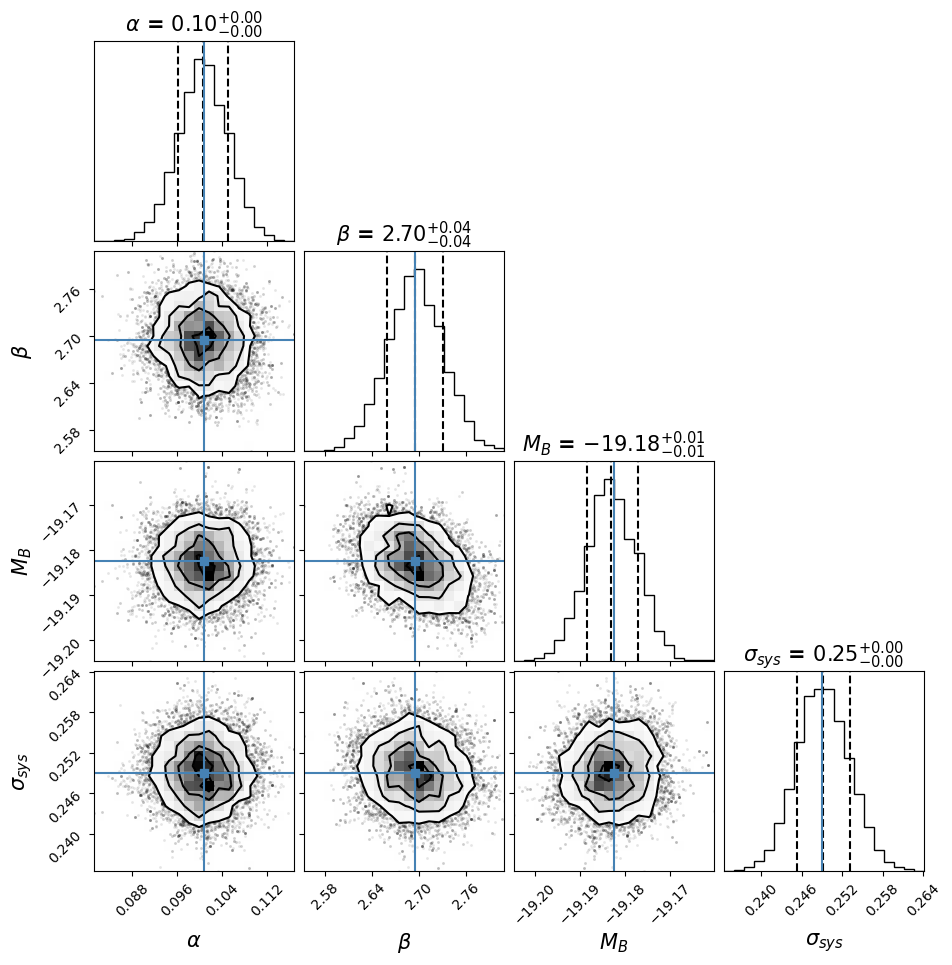

In [12]:
# Plot the Hubble diagram
plt.plot(np.sort(z),cosmo.distmod(np.sort(z)).base,'-b')
plt.errorbar(z,mb-m_mcmc[0] + a_mcmc[0] * st - b_mcmc[0] * col,yerr=np.sqrt(emb**2+ (a_mcmc[0]*est)**2 + (b_mcmc[0] * ecol)**2),c='k', capsize=0,fmt='.',label='EMCEE')
plt.ylabel(r'$\mu$ [mag]',fontsize=20)
plt.legend()
plt.ylim(30,40)

# Plot the residual
plt.figure(figsize=(21, 5))
plt.plot(np.sort(z),z*0.,'-b')
plt.errorbar(z,mb-m_mcmc[0] + a_mcmc[0] * st - b_mcmc[0] * col-cosmo.distmod(z.to_list()).base,yerr=np.sqrt(emb**2+ (a_mcmc[0]*est)**2 + (b_mcmc[0] * ecol)**2),c='k', capsize=0,fmt='.')
plt.xlabel('Redshift')
plt.ylabel('Residual')
plt.ylim(-2,2)

# Add horizontal lines at 3*rms
plt.hlines(y=[-3*rms, 3*rms], xmin=min(z), xmax=max(z), colors='r', linestyles='--')
plt.show()


fig, ax = plt.subplots(4,1,figsize=(10,10), sharex=True)
plt.sca(ax[0])
plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.ylabel(r'$\alpha$',fontsize=20)
plt.sca(ax[1])
plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
plt.ylabel(r'$\beta$',fontsize=20)
plt.sca(ax[2])
plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)
plt.ylabel('M',fontsize=20)
plt.sca(ax[3])
plt.plot(sampler.chain[:,:,3].T, '-', color='k', alpha=0.3)
plt.ylabel(r'$\sigma$',fontsize=20)
plt.xlabel('samples',fontsize=20)
plt.show()
plt.close("all")


fig = corner.corner(samples, labels=[r"$\alpha$", r"$\beta$", r"$M_B$", r"$\sigma_{sys}$"],truths=result["x"],
                    label_kwargs={"fontsize": 15},quantiles=[0.16, 0.5, 0.84],show_titles=True, 
                    title_kwargs={"fontsize": 15,"fontweight":'bold'})
plt.show()
plt.close("all")

tab['mures']=tab['c']*np.nan
tab['emures']=tab['c']*np.nan
tab['mures'] = (mb-m_mcmc[0] + a_mcmc[0] * st - b_mcmc[0] * col) - cosmo.distmod(tab['z'].to_list()).base
tab['emures']=np.sqrt(emb**2+m_mcmc[1]**2+(a_mcmc[1]*est)**2+(b_mcmc[1]*ecol)**2)

In [13]:
# 3-sigma clipping
def sigma_clip(data, m=3):
    mean = np.mean(data)
    mask = (data > mean - m * rms) & (data < mean + m * rms)
    return data[mask]

clipped_residuals = sigma_clip(residuals)

z_3 = z[clipped_residuals.index]
emb_3 = np.sqrt((a_mcmc[0] * est)**2 + (b_mcmc[0] * ecol)**2)[clipped_residuals.index]

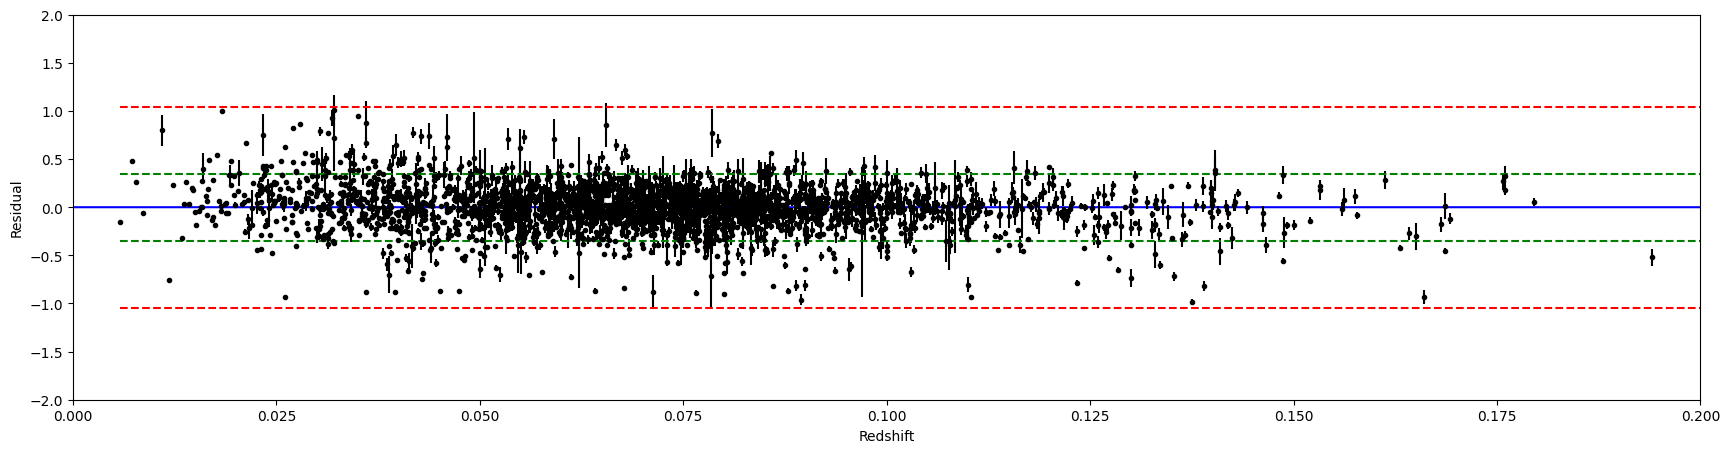

In [15]:
mask_3rms = (clipped_residuals > -3*rms) & (clipped_residuals < 3*rms)

clipped_residuals = clipped_residuals[mask_3rms]
z_3 = z_3[mask_3rms]
emb_3 = emb_3[mask_3rms]

# Plot with the clipped data
plt.figure(figsize=(21, 5))
plt.plot(np.sort(z), z*0., '-b')
plt.errorbar(z_3, clipped_residuals, yerr=emb_3, c='k', capsize=0, fmt='.')
plt.xlabel('Redshift')
plt.ylabel('Residual')
plt.ylim(-2,2)
plt.xlim(0, 0.2)
plt.hlines(y=[-3*rms, 3*rms], xmin=min(z_3), xmax=max(z_3), colors='r', linestyles='--')
plt.show()

Bin 1 limits: -0.6 - -0.52
Bin 2 limits: -0.52 - -0.43999999999999995
Bin 3 limits: -0.43999999999999995 - -0.36
Bin 4 limits: -0.36 - -0.27999999999999997
Bin 5 limits: -0.27999999999999997 - -0.19999999999999996
Bin 6 limits: -0.19999999999999996 - -0.12
Bin 7 limits: -0.12 - -0.039999999999999925
Bin 8 limits: -0.039999999999999925 - 0.040000000000000036
Bin 9 limits: 0.040000000000000036 - 0.12
Bin 10 limits: 0.12 - 0.20000000000000007
Bin 11 limits: 0.20000000000000007 - 0.28
Bin 12 limits: 0.28 - 0.36
Bin 13 limits: 0.36 - 0.44000000000000006
Bin 14 limits: 0.44000000000000006 - 0.5200000000000001
Bin 15 limits: 0.5200000000000001 - 0.6


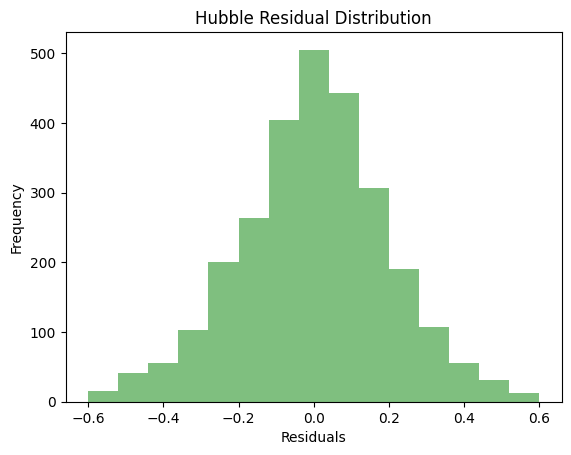

In [23]:
# Plot the frequency of  the clipped residuals
bins = np.linspace(-0.6, 0.6, 16)

bin_counts, bin_edges = np.histogram(clipped_residuals, bins=bins)

plt.hist(clipped_residuals, bins=bins, alpha=0.5, color='g')

# Print the bin limits
for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]
    print(f"Bin {i+1} limits: {bin_start} - {bin_end}")

plt.title('Hubble Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()